# Introducción de Free Float en el Índice 

Basaremos la metodología de introudcción en la utilizada por otros índices de éxito como el IBEX35. El capital flotante real de la empresa caerá dentro de unos margenes, que determinarán el coeficiente a utilizar en el índice. Cae también bajo mi elección el disminuir el volumen de acciones seleccionado si se producen sobreponderaciones.

https://www.bolsasymercados.es/bme-exchange/docs/docsSubidos/Indices/Regulacion/Normas_Indices_Ibex_esp.pdf

In [124]:
import pandas as pd
import eikon as ek
import warnings
warnings.filterwarnings('ignore')
from funcs_tfm import *
import pyfolio as pf
import numpy as np

ek.set_app_key('f5c3af98ce3e4070aba80b9bc465cd82b9624cfc')

path = '/Users/ruben/Documents/MASTER/TFM/data/'
a = pd.read_csv(path + 'gold.csv')
a1=a.drop(['Unnamed: 0'], axis=1) # General data for Index

b = pd.read_csv(path + 'full.csv')
b1 = b.drop(['Unnamed: 0'], axis=1) # Returns from the index

c = pd.read_csv(path + 'b_index.csv')
c1 = c.drop(['Instrument.1', 'Date.1'], axis=1) # Returns from the companies

In [11]:
# Creación de la base de datos con el Free Float de los activos y las rentabilidades y capitalización de mercado
ff, err = ek.get_data(a1['Instrument'].to_list(), ['TR.FreeFloatPct', 'TR.FreeFloatPct.date'])
ff['ff_coef'] = ff['Free Float (Percent)'].apply(coef_flotante)
ff['ff_coef'] = (ff['ff_coef']/100)
adj_index = c1.merge(ff, on='Instrument', how='left')
adj_index.drop(['Date_y'], axis=1, inplace=True)
adj_index.rename(columns={'Date_x':'Date'}, inplace=True)
adj_index['coef_adj'] = adj_index['weight'].apply(adj_sobrepon)
adj_index['coef_real'] = adj_index['ff_coef'] - adj_index['coef_adj']
adj_index['cap_adj'] = adj_index['coef_real']*adj_index['Company Market Cap']
adj_index # Previous to c_index

,Instrument,Date,Close Price,Company Market Cap,weight,rent_diaria,rent_index,Free Float (Percent),ff_coef,coef_adj,coef_real,cap_adj
0,ABBN.S,2018-04-20T00:00:00Z,19.090223,4.288649e+10,0.047874,NaN,NaN,85.7984,1.0,0.0,1.0,4.288649e+10
1,ABBN.S,2018-04-23T00:00:00Z,19.233993,4.320947e+10,0.048163,0.007531,0.000363,85.7984,1.0,0.0,1.0,4.320947e+10
2,ABBN.S,2018-04-24T00:00:00Z,19.061196,4.282128e+10,0.048012,-0.008984,-0.000431,85.7984,1.0,0.0,1.0,4.282128e+10
3,ABBN.S,2018-04-25T00:00:00Z,18.529715,4.162730e+10,0.047115,-0.027883,-0.001314,85.7984,1.0,0.0,1.0,4.162730e+10
4,ABBN.S,2018-04-26T00:00:00Z,18.662520,4.192565e+10,0.047028,0.007167,0.000337,85.7984,1.0,0.0,1.0,4.192565e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
57085,WRT1V.HE,2023-04-14T00:00:00Z,8.764000,5.185864e+09,0.004535,0.008052,0.000037,78.3648,1.0,0.0,1.0,5.185864e+09
57086,WRT1V.HE,2023-04-17T00:00:00Z,8.780000,5.195331e+09,0.004530,0.001826,0.000008,78.3648,1.0,0.0,1.0,5.195331e+09
57087,WRT1V.HE,2023-04-18T00:00:00Z,8.852000,5.237935e+09,0.004555,0.008200,0.000037,78.3648,1.0,0.0,1.0,5.237935e+09
57088,WRT1V.HE,2023-04-19T00:00:00Z,8.830000,5.224918e+09,0.004527,-0.002485,-0.000011,78.3648,1.0,0.0,1.0,5.224918e+09


In [12]:
# Pesos con ajuste Free Float 
total_cap = []
adj_index['weight_adj'] = 0
al = adj_index.sort_values(by=['Date'], inplace=False, ascending=True)

for i in al['Date'].unique(): # Calculo de la capitalización total de cada fecha
   total_cap.append(sum(adj_index[adj_index['Date']==i]['cap_adj']))

full = pd.DataFrame(columns = ['Date', 'total_cap_adj'])
full['total_cap_adj']= total_cap
full['Date'] = al['Date'].unique()
full.sort_values(by=['Date'], inplace=True, ascending=True)

for i, v in zip(adj_index['Date'], range(len(adj_index))): # Calculo de los pesos de cada stock en cada fecha
    adj_index['weight_adj'].iloc[v]=adj_index[adj_index['Date']==i]['cap_adj'][v]/full[full['Date']==i]['total_cap_adj']

adj_index.to_csv(path + 'weight_ind.csv') # DB of adj weights and rets of each stock
index = pd.MultiIndex.from_frame(adj_index[['Date','weight_adj']])
c_index = adj_index.set_index(index, inplace= False)
c_index.sort_index(level=['Date', 'weight_adj'], inplace=True, ascending=[True, False])
c_index['rent_index_adj'] = c_index['weight_adj']*c_index['rent_diaria']
c_index # Returns old/new from index constituents (FF adj)

Instrument                  Date  Close Price  \
Date                 weight_adj                                                 
2018-04-20T00:00:00Z 0.144607       NOVN.S  2018-04-20T00:00:00Z    56.178240   
                     0.085863        DGE.L  2018-04-20T00:00:00Z    28.094849   
                     0.062135      SGEF.PA  2018-04-20T00:00:00Z    84.500000   
                     0.053274       ABBN.S  2018-04-20T00:00:00Z    19.090223   
                     0.051629     ATCOa.ST  2018-04-20T00:00:00Z     6.292775   
...                                    ...                   ...          ...   
2023-04-20T00:00:00Z 0.003269     ELUXb.ST  2023-04-20T00:00:00Z    12.077629   
                     0.002499      FRAG.DE  2023-04-20T00:00:00Z    47.380000   
                     0.001540      DWNG.DE  2023-04-20T00:00:00Z    20.240000   
                     0.001120     SHA_p.DE  2023-04-20T00:00:00Z     7.090000   
                     0.000516      CORA.LS  2023-04-20T00:00:00Z    10.200000   

                                 Company Market Cap    weight  rent_diaria  \
Date                 weight_adj                                              
2018-04-20T00:00:00Z 0.144607          1.663023e+11  0.185641          NaN   
                     0.085863          6.912154e+10  0.077160          NaN   
                     0.062135          5.001999e+10  0.055837          NaN   
                     0.053274          4.288649e+10  0.047874          NaN   
                     0.051629          4.156208e+10  0.046395          NaN   
...                                             ...       ...          ...   
2023-04-20T00:00:00Z 0.003269          3.435213e+09  0.002967     0.013033   
                     0.002499          4.375984e+09  0.003780     0.004239   
                     0.001540          8.092426e+09  0.006990    -0.028791   
                     0.001120          1.176940e+09  0.001017    -0.011847   
                     0.000516          1.354995e+09  0.001170     0.000000   

                                 rent_index  Free Float (Percent)  ff_coef  \
Date                 weight_adj                                              
2018-04-20T00:00:00Z 0.144607           NaN               95.5606      1.0   
                     0.085863           NaN               99.8255      1.0   
                     0.062135           NaN                89.329      1.0   
                     0.053274           NaN               85.7984      1.0   
                     0.051629           NaN               76.4117      1.0   
...                                     ...                   ...      ...   
2023-04-20T00:00:00Z 0.003269      0.000039               99.5868      1.0   
                     0.002499      0.000016               39.2776      0.6   
                     0.001540     -0.000201               12.3966      0.2   
                     0.001120     -0.000012               74.9887      1.0   
                     0.000516      0.000000               28.5924      0.4   

                                 coef_adj  coef_real       cap_adj  weight_adj  
Date                 weight_adj                                                 
2018-04-20T00:00:00Z 0.144607         0.3        0.7  1.164116e+11    0.144607  
                     0.085863         0.0        1.0  6.912154e+10    0.085863  
                     0.062135         0.0        1.0  5.001999e+10    0.062135  
                     0.053274         0.0        1.0  4.288649e+10    0.053274  
                     0.051629         0.0        1.0  4.156208e+10    0.051629  
...                                   ...        ...           ...         ...  
2023-04-20T00:00:00Z 0.003269         0.0        1.0  3.435213e+09    0.003269  
                     0.002499         0.0        0.6  2.625590e+09    0.002499  
                     0.001540         0.0        0.2  1.618485e+09    0.001540  
                     0.001120         0.0        1.0  1.1

In [13]:
# Rentabilidad y capitalización diaria del índice
full_1 =  pd.DataFrame(full, columns = ['Date', 'total_cap_adj', 'tot_rent_adj'])
for i, v in zip(c_index['Date'].unique(), range(len(c_index['Date'].unique()))):
    full_1['tot_rent_adj'].iloc[v]=c_index.loc[i]['rent_index_adj'].sum()

full_2 =  pd.DataFrame(full_1, columns = ['Date', 'total_cap_adj', 'tot_rent_adj', 'net value adj'])
full_2['net value adj'].iloc[0]=1000 # Valor inicial del índice
for i in range(len(full_2)): # Valor neto del índice
    try:
        full_2['net value adj'].iloc[i+1]=full_2['net value adj'].iloc[i]*(1+full_2['tot_rent_adj'].iloc[i+1])
    except IndexError:
            pass
    
full_2.to_csv(path + 'index_adj.csv') # Daily capital/ Return/ NV of the index
full_2

,Date,total_cap_adj,tot_rent_adj,net value adj
0,2018-04-20T00:00:00Z,8.050192e+11,0.000000,1000.000000
1,2018-04-23T00:00:00Z,8.062988e+11,0.001744,1001.743670
2,2018-04-24T00:00:00Z,8.015090e+11,-0.005689,996.044339
3,2018-04-25T00:00:00Z,7.933183e+11,-0.009909,986.174622
4,2018-04-26T00:00:00Z,8.004350e+11,0.009059,995.108204
...,...,...,...,...
1288,2023-04-14T00:00:00Z,1.037614e+12,0.002644,1744.760309
1289,2023-04-17T00:00:00Z,1.040227e+12,0.002916,1749.847520
1290,2023-04-18T00:00:00Z,1.043993e+12,0.004400,1757.546450
1291,2023-04-19T00:00:00Z,1.047385e+12,0.003249,1763.257087


In [28]:
# new rets db with adj
full_2['Date'] = pd.to_datetime(full_2['Date'])
full_2['Date'] = full_2['Date'].dt.strftime('%Y-%m-%d')
rets = pd.read_csv(path + 'rets.csv')
rets_adj = rets.merge(full_2, on = 'Date', how = 'left')
rets_adj.drop(columns = ['total_cap_adj', 'net value adj'], inplace = True)
rets_adj = rets_adj[['Date', 'tot_rent', 'tot_rent_adj', '.FT4GDGLOB100', '.STOXX50E', '.FTSE', '.STOXX50',
       '.SXWESGP', '.MIWO00000PUS', '.NDX']]
rets_adj.to_csv(path + 'rets.csv') # full rets lists with old and new and benchmarks

In [145]:
b = []
for i in c_index['Date'].unique():
    a = c_index.loc[i]['Instrument'].count()<45
    if a == True:
        b.append(i)
    else:
        pass
b

['2018-04-27T00:00:00Z',
 '2018-05-01T00:00:00Z',
 '2018-05-03T00:00:00Z',
 '2018-05-07T00:00:00Z',
 '2018-05-10T00:00:00Z',
 '2018-05-11T00:00:00Z',
 '2018-05-17T00:00:00Z',
 '2018-05-21T00:00:00Z',
 '2018-05-28T00:00:00Z',
 '2018-05-31T00:00:00Z',
 '2018-06-04T00:00:00Z',
 '2018-06-05T00:00:00Z',
 '2018-06-06T00:00:00Z',
 '2018-06-22T00:00:00Z',
 '2018-07-04T00:00:00Z',
 '2018-08-01T00:00:00Z',
 '2018-08-15T00:00:00Z',
 '2018-08-27T00:00:00Z',
 '2018-09-03T00:00:00Z',
 '2018-10-03T00:00:00Z',
 '2018-10-26T00:00:00Z',
 '2018-11-01T00:00:00Z',
 '2018-11-12T00:00:00Z',
 '2018-11-22T00:00:00Z',
 '2018-12-05T00:00:00Z',
 '2018-12-06T00:00:00Z',
 '2018-12-24T00:00:00Z',
 '2018-12-26T00:00:00Z',
 '2018-12-31T00:00:00Z',
 '2019-01-02T00:00:00Z',
 '2019-01-21T00:00:00Z',
 '2019-02-18T00:00:00Z',
 '2019-04-18T00:00:00Z',
 '2019-04-22T00:00:00Z',
 '2019-05-01T00:00:00Z',
 '2019-05-03T00:00:00Z',
 '2019-05-06T00:00:00Z',
 '2019-05-17T00:00:00Z',
 '2019-05-27T00:00:00Z',
 '2019-05-30T00:00:00Z',


In [143]:
import numpy as np
a = c_index.groupby(c_index.Date)['Instrument'].count()<45
a.groupby(a.values).count()

False    1147
True      146
Name: Instrument, dtype: int64

In [191]:
c = c_index.loc[b].groupby(c_index.loc[b].index.get_level_values('Date'))['Instrument'].count()<40
d = c.groupby(c.values).count()
print('True Ratio:',d[1]/(d[0]+d[1]))
d

True Ratio: 0.2328767123287671


False    112
True      34
Name: Instrument, dtype: int64

In [198]:
d = []
for i in c.index:
    if c.loc[i]== True:
       d.append(i)
    else:
        pass

d.__len__()

34

In [249]:
null_index = adj_index.drop(adj_index[adj_index['Date'].isin(d)].index)
null_index.drop(columns = ['weight_adj'], inplace = True) #DF sin las fechas con menos de 40 activos en el índice
null_index.reset_index(inplace=True)
null_index

,index,Instrument,Date,Close Price,Company Market Cap,weight,rent_diaria,rent_index,Free Float (Percent),ff_coef,coef_adj,coef_real,cap_adj
0,0,ABBN.S,2018-04-20T00:00:00Z,19.090223,4.288649e+10,0.047874,NaN,NaN,85.7984,1.0,0.0,1.0,4.288649e+10
1,1,ABBN.S,2018-04-23T00:00:00Z,19.233993,4.320947e+10,0.048163,0.007531,0.000363,85.7984,1.0,0.0,1.0,4.320947e+10
2,2,ABBN.S,2018-04-24T00:00:00Z,19.061196,4.282128e+10,0.048012,-0.008984,-0.000431,85.7984,1.0,0.0,1.0,4.282128e+10
3,3,ABBN.S,2018-04-25T00:00:00Z,18.529715,4.162730e+10,0.047115,-0.027883,-0.001314,85.7984,1.0,0.0,1.0,4.162730e+10
4,4,ABBN.S,2018-04-26T00:00:00Z,18.662520,4.192565e+10,0.047028,0.007167,0.000337,85.7984,1.0,0.0,1.0,4.192565e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56377,57085,WRT1V.HE,2023-04-14T00:00:00Z,8.764000,5.185864e+09,0.004535,0.008052,0.000037,78.3648,1.0,0.0,1.0,5.185864e+09
56378,57086,WRT1V.HE,2023-04-17T00:00:00Z,8.780000,5.195331e+09,0.004530,0.001826,0.000008,78.3648,1.0,0.0,1.0,5.195331e+09
56379,57087,WRT1V.HE,2023-04-18T00:00:00Z,8.852000,5.237935e+09,0.004555,0.008200,0.000037,78.3648,1.0,0.0,1.0,5.237935e+09
56380,57088,WRT1V.HE,2023-04-19T00:00:00Z,8.830000,5.224918e+09,0.004527,-0.002485,-0.000011,78.3648,1.0,0.0,1.0,5.224918e+09


In [250]:
# Pesos con ajuste Free Float 
total_cap_1 = []
null_index['weight_adj'] = 0
al1 = null_index.sort_values(by=['Date'], inplace=False, ascending=True)

for i in al1['Date'].unique(): # Calculo de la capitalización total de cada fecha
   total_cap_1.append(sum(null_index[null_index['Date']==i]['cap_adj']))

full_1 = pd.DataFrame(columns = ['Date', 'total_cap_adj'])
full_1['total_cap_adj']= total_cap_1
full_1['Date'] = al1['Date'].unique()
full_1.sort_values(by=['Date'], inplace=True, ascending=True)

for i, v in zip(null_index['Date'], range(len(null_index))): # Calculo de los pesos de cada stock en cada fecha
    null_index['weight_adj'].iloc[v]=null_index[null_index['Date']==i]['cap_adj'][v]/full_1[full_1['Date']==i]['total_cap_adj']

null_index.to_csv(path + 'weight_ind_null.csv') # DB of adj weights and rets of each stock
index = pd.MultiIndex.from_frame(null_index[['Date','weight_adj']])
c_index_1 = null_index.set_index(index, inplace= False)
c_index_1.sort_index(level=['Date', 'weight_adj'], inplace=True, ascending=[True, False])
c_index_1['rent_index_adj'] = c_index_1['weight_adj']*c_index_1['rent_diaria']
c_index_1 # Returns old/new from index constituents (FF adj)

# Rentabilidad y capitalización diaria del índice
full_1 =  pd.DataFrame(full_1, columns = ['Date', 'total_cap_adj', 'tot_rent_adj'])
for i, v in zip(c_index_1['Date'].unique(), range(len(c_index_1['Date'].unique()))):
    full_1['tot_rent_adj'].iloc[v]=c_index_1.loc[i]['rent_index_adj'].sum()

full_3 =  pd.DataFrame(full_1, columns = ['Date', 'total_cap_adj', 'tot_rent_adj', 'net value adj'])
full_3['net value adj'].iloc[0]=1000 # Valor inicial del índice
for i in range(len(full_3)): # Valor neto del índice
    try:
        full_3['net value adj'].iloc[i+1]=full_3['net value adj'].iloc[i]*(1+full_3['tot_rent_adj'].iloc[i+1])
    except IndexError:
            pass
    
full_3.to_csv(path + 'index_adj_null.csv') # Daily capital/ Return/ NV of the index sin fechas con menos de 40 constituyentes
full_3

,Date,total_cap_adj,tot_rent_adj,net value adj
0,2018-04-20T00:00:00Z,8.050192e+11,0.000000,1000.000000
1,2018-04-23T00:00:00Z,8.062988e+11,0.001744,1001.743670
2,2018-04-24T00:00:00Z,8.015090e+11,-0.005689,996.044339
3,2018-04-25T00:00:00Z,7.933183e+11,-0.009909,986.174622
4,2018-04-26T00:00:00Z,8.004350e+11,0.009059,995.108204
...,...,...,...,...
1254,2023-04-14T00:00:00Z,1.037614e+12,0.002644,1704.877535
1255,2023-04-17T00:00:00Z,1.040227e+12,0.002916,1709.848460
1256,2023-04-18T00:00:00Z,1.043993e+12,0.004400,1717.371404
1257,2023-04-19T00:00:00Z,1.047385e+12,0.003249,1722.951503


In [3]:
full = pd.read_csv(path + 'index_adj.csv')
full

,Unnamed: 0,Date,total_cap_adj,tot_rent_adj,net value adj
0,0,2018-04-20T00:00:00Z,8.050192e+11,0.000000,1000.000000
1,1,2018-04-23T00:00:00Z,8.062988e+11,0.001744,1001.743670
2,2,2018-04-24T00:00:00Z,8.015090e+11,-0.005689,996.044339
3,3,2018-04-25T00:00:00Z,7.933183e+11,-0.009909,986.174622
4,4,2018-04-26T00:00:00Z,8.004350e+11,0.009059,995.108204
...,...,...,...,...,...
1288,1288,2023-04-14T00:00:00Z,1.037614e+12,0.002644,1744.760309
1289,1289,2023-04-17T00:00:00Z,1.040227e+12,0.002916,1749.847520
1290,1290,2023-04-18T00:00:00Z,1.043993e+12,0.004400,1757.546450
1291,1291,2023-04-19T00:00:00Z,1.047385e+12,0.003249,1763.257087


In [9]:
full['total_cap_adj'][1292]

1050852363745.4991

In [52]:
# Index constituents and weights for indices (pesos no encontrados hay que mirar más -> comentarlo en PPT)
index_con = ['.SXWESGP','.FTSE', '.STOXX50', '.STOXX50E', '.NDX', '.FT4GDGLOB100', '.SX5EESG']
teta=pd.DataFrame(columns = ['Index'])
for i in index_con:
    ab, err = ek.get_data(i, ['TR.IndexConstituentRIC','TR.IndexConstituentWeightPercent'])
    teta.insert(0, str(i) ,ab['Constituent RIC'])
    teta.insert(0, str(i+' weight') ,ab['Weight percent'])
teta.drop('Index', axis=1, inplace=True)
teta

KeyError: 'TR.INDEXCONSTITUENTRIC'

In [73]:
# Index constituents and weights for indices (pesos no encontrados hay que mirar más -> comentarlo en PPT)
index_con = ['EU0009658145','.STOXX50E','CH0469557521', '.SX5GTESG', '.SX5KESG']
# Euro Stoxx 50 es .STOXX50E con ISIN EU0009658145
# Euro Stoxx 50 ESG es .SX5EESG con ISIN CH0469557521
teta=pd.DataFrame(columns = ['Index'])
for i in index_con:
    ab, err = ek.get_data(i, ['TR.IndexConstituentRIC','TR.IndexConstituentWeightPercent'])
    try:
        teta.insert(0, str(i) , ab['Constituent RIC'])
        teta.insert(0, str(i+' weight') , ab['Weight percent'])
    except KeyError:
        teta.insert(0, str(i) , ab['TR.INDEXCONSTITUENTRIC'])
        teta.insert(0, str(i+' weight') , ab['TR.INDEXCONSTITUENTWEIGHTPERCENT'])
teta.drop('Index', axis=1, inplace=True)
teta

,.SX5KESG weight,.SX5KESG,.SX5GTESG weight,.SX5GTESG,CH0469557521 weight,CH0469557521,.STOXX50E weight,.STOXX50E,EU0009658145 weight,EU0009658145
0,<NA>,<NA>,2.441174,<NA>,2.441174,<NA>,<NA>,DHLn.DE,<NA>,DHLn.DE
1,<NA>,<NA>,2.234282,<NA>,2.234282,<NA>,<NA>,PERP.PA,<NA>,PERP.PA
2,<NA>,<NA>,1.441311,<NA>,1.441311,<NA>,<NA>,NDAFI.HE,<NA>,NDAFI.HE
3,<NA>,<NA>,3.281367,<NA>,3.281367,<NA>,<NA>,AIRP.PA,<NA>,AIRP.PA
4,<NA>,<NA>,1.483173,<NA>,1.483173,<NA>,<NA>,VNAn.DE,<NA>,VNAn.DE
5,<NA>,<NA>,2.021249,<NA>,2.021249,<NA>,<NA>,IBE.MC,<NA>,IBE.MC
6,<NA>,<NA>,1.05321,<NA>,1.05321,<NA>,<NA>,SIEGn.DE,<NA>,SIEGn.DE
7,<NA>,<NA>,2.469419,<NA>,2.469419,<NA>,<NA>,SAN.MC,<NA>,SAN.MC
8,<NA>,<NA>,2.745513,<NA>,2.745513,<NA>,<NA>,VOWG_p.DE,<NA>,VOWG_p.DE
9,<NA>,<NA>,4.536512,<NA>,4.536512,<NA>,<NA>,SAPG.DE,<NA>,SAPG.DE


In [72]:
teta[['.STOXX50', '.STOXX50E']].sort_values(by=['.STOXX50', '.STOXX50E'], inplace=False, ascending=[True, True])

,.STOXX50,.STOXX50E
0,ABBN.S,DHLn.DE
48,ABI.BR,ADSGn.DE
7,ADYEN.AS,SAN.MC
10,AIR.PA,CRDI.MI
15,AIRP.PA,SASY.PA
44,ALVG.DE,AXAF.PA
17,ASML.AS,ASML.AS
47,AXAF.PA,ISP.MI
27,AZN.L,OREP.PA
34,BASFn.DE,BAYGn.DE


In [28]:
# GHG emissions de diferentes índices

ghg_emi = teta[['.STOXX50','.STOXX50E','.FTSE','.NDX']]
for i in ghg_emi.columns:
    ghg, err = ek.get_data(ghg_emi[i].dropna().tolist(),['TR.AnalyticGHGEmissionsScope1and2and3(Period=FY0).date', 'TR.AnalyticGHGEmissionsScope1and2and3(Period=FY0)'])
    print('Las emisiones totales en Millones de '+i+' son: ', ghg.sum()) 

Las emisiones totales en Millones de .STOXX50 son:  GHG Emissions Scope 1,2,3 to Revenue USD in million    63687.715503
dtype: float64
Las emisiones totales en Millones de .STOXX50E son:  GHG Emissions Scope 1,2,3 to Revenue USD in million    49206.470379
dtype: float64
Las emisiones totales en Millones de .FTSE son:  GHG Emissions Scope 1,2,3 to Revenue USD in million    73839.190555
dtype: float64
Las emisiones totales en Millones de .NDX son:  GHG Emissions Scope 1,2,3 to Revenue USD in million    33907.071116
dtype: float64


In [33]:
stoxxe = ghg_emi['.STOXX50E'].dropna().tolist()
b3 = pd.read_csv(path + 'b3.csv')
testt = b3[b3['Instrument'].isin(stoxxe)]
testt['ESG Score']

24    83.165001
Name: ESG Score, dtype: float64

Diferencia de rentabilidad acumulada entre el índice con y sin nulos es negligible!!

# ENTREGA FINAL

In [2]:
import pandas as pd
import eikon as ek
import warnings
warnings.filterwarnings('ignore')
from funcs_tfm import *
import pyfolio as pf

#ek.set_app_key('f5c3af98ce3e4070aba80b9bc465cd82b9624cfc')

path = '/Users/ruben/Documents/MASTER/TFM/data/'
a = pd.read_csv(path + 'gold.csv')
a1=a.drop(['Unnamed: 0'], axis=1) # General data for Index

b = pd.read_csv(path + 'full.csv')
b1 = b.drop(['Unnamed: 0'], axis=1) # Returns from the index

c = pd.read_csv(path + 'b_index.csv')
c1 = c.drop(['Instrument.1', 'Date.1'], axis=1) # Returns from the companies

## Datos Generales del Índice

In [23]:
# Datos Generales sin Paises
show = a1[['Name', 'Instrument',
           'ISIN', 
           'TRBC Economic Sector Name', 
           'ESG Score', 
           'totalEsg', 
           'mkt_cap_2023_EUR' ]]
show['ESG Score'] = show['ESG Score'].round(2)
show.rename(columns={'ESG Score':'Refinitiv ESG Score', 'totalEsg':'Sustainalytics ESG Score', 'mkt_cap_2023_EUR':'Company Market Cap'}, inplace=True)
show['Company Market Cap'] = show['Company Market Cap'].apply(lambda x: "{:,}".format(x))
show.head()

,Name,Instrument,ISIN,TRBC Economic Sector Name,Refinitiv ESG Score,Sustainalytics ESG Score,Company Market Cap
0,SYMRISE AG,SY1G.DE,DE000SYM9999,Basic Materials,77.41,20.32,"14,951,877,511.5549"
1,GIVAUDAN SA,GIVN.S,CH0010645932,Basic Materials,76.88,19.30,"29,729,067,677.9475"
2,SMURFIT KAPPA GP,SKG.I,IE00B1RR8406,Basic Materials,84.93,11.11,"8,764,425,267.78"
3,UPM-KYMMENE OYJ,UPM.HE,FI0009005987,Basic Materials,89.65,14.68,"15,894,649,116.22"
4,CORTICEIRA AMORIM,CORA.LS,PTCOR0AE0006,Basic Materials,77.52,13.45,"1,354,995,101.37911"


In [ ]:
# Datos generales a excel para TFM
countries = ek.get_data(a1.Instrument.unique().tolist(),['TR.HeadquartersCountry','TR.ExchangeCountry','CURRENCY'])
show_c = show.merge(countries[0][['Instrument', 'Country of Headquarters']], on = 'Instrument', how = 'left')
show_c.drop(columns = ['Instrument'], inplace = True)
show_c.set_index('Name').to_excel(path + 'show_c.xlsx')

## Visualización Sectorial

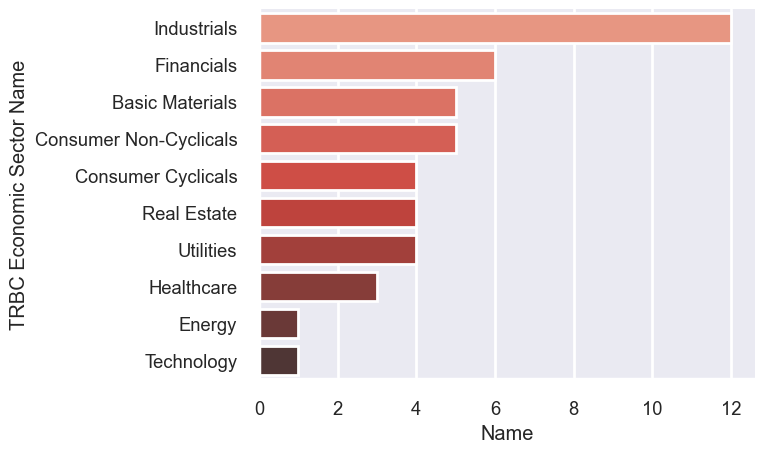

In [49]:
# Gráfico de barras con el número de empresas por sector
import seaborn as sns

plot_cont = show_c.groupby('TRBC Economic Sector Name').count().sort_values(by = 'Name', ascending=False)
sns.set_theme(style="darkgrid")
sns.set_context("poster", font_scale=0.6)
sns.barplot(x=plot_cont.Name, y=plot_cont.index, data=plot_cont, palette='Reds_d')
sns.despine()

In [34]:
cap = pd.read_csv(path + 'weight_ind_null.csv')
weights_check = cap.loc[cap['Date'] == '2023-04-20T00:00:00Z'][['Instrument', 'cap_adj', 'weight_adj', 'Free Float (Percent)']]
weights_check.sort_values(by = 'weight_adj', ascending=False, inplace=True)

In [55]:
show_big = a1[['ISIN', 'Name',
       'Instrument', 'ESG Score', 'totalEsg',
        'Market Cap Category',
       'TRBC Economic Sector Name',
       'GHG Emissions Scope 1,2,3 to Revenue USD in million', 
        'mkt_cap_2023_EUR',
       'weight_adj_2023']]
show_big = show_big.merge(weights_check, on = 'Instrument', how = 'left')
show_big['mkt_cap_2023_EUR'] = show_big['mkt_cap_2023_EUR'].apply(lambda x: "{:,} €".format(x))
show_big['Free Float (Percent)'] = show_big['Free Float (Percent)'].apply(lambda x: "{:} %".format(x))
show_big['GHG Emissions Scope 1,2,3 to Revenue USD in million'] = show_big['GHG Emissions Scope 1,2,3 to Revenue USD in million'].apply(lambda x: "{:.2} M$".format(x))
show_big['weight_adj_2023'] = show_big['weight_adj_2023'].apply(lambda x: "{:.2%}".format(x))
show_big.rename(columns={'ESG Score':'Refinitiv ESG Score', 
                         'totalEsg':'Sustainalytics ESG Score', 
                         'mkt_cap_2023_EUR':'Company Market Cap', 
                         'weight_adj_2023': 'Peso con Flotación', 
                         'Free Float (Percent)':'Capital Flotante'}).drop(columns = ['Instrument', 'cap_adj', 'weight_adj']).set_index('Name').to_excel(path + 'show_big.xlsx')
show_big

,ISIN,Name,Instrument,ESG Score,totalEsg,Market Cap Category,TRBC Economic Sector Name,"GHG Emissions Scope 1,2,3 to Revenue USD in million",mkt_cap_2023_EUR,weight_adj_2023,cap_adj,weight_adj,Free Float (Percent)
0,CH0012005267,NOVARTIS AG,NOVN.S,85.266345,17.23,Large Cap,Healthcare,2e+01 M$,"205,199,735,767.44 €",13.67%,1.436398e+11,0.136689,95.5606 %
1,GB0002374006,DIAGEO,DGE.L,79.892964,16.69,Large Cap,Consumer Non-Cyclicals,2.1e+02 M$,"94,576,718,704.8285 €",9.00%,9.457672e+10,0.090000,99.8255 %
2,CH0210483332,COMPAGNIE FINANCIERE RICHEMONT SA,CFR.S,79.041007,10.97,Large Cap,Consumer Cyclicals,7.5e+01 M$,"80,218,451,228.5618 €",7.63%,8.021845e+10,0.076337,99.9877 %
3,FR0000125486,VINCI,SGEF.PA,83.165001,17.36,Large Cap,Industrials,2.9e+02 M$,"65,134,468,285.4 €",6.20%,6.513447e+10,0.061983,89.329 %
4,CH0012221716,ABB LTD,ABBN.S,92.034925,17.23,Large Cap,Industrials,4.3e+03 M$,"63,318,485,270.4579 €",6.03%,6.331849e+10,0.060254,85.7984 %
5,GB00B2B0DG97,RELX,REL.L,84.661418,18.45,Large Cap,Industrials,6.2 M$,"58,041,615,778.5472 €",5.52%,5.804162e+10,0.055233,99.5758 %
6,SE0017486889,ATLAS COPCO AB,ATCOa.ST,84.948560,18.36,Large Cap,Industrials,1.6e+04 M$,"54,836,447,740.9008 €",5.22%,5.483645e+10,0.052183,76.4117 %
7,DK0060079531,DSV A/S,DSV.CO,80.277131,14.08,Large Cap,Industrials,4.7e+02 M$,"37,290,073,715.9387 €",3.55%,3.729007e+10,0.035486,81.4067 %
8,IE00BK9ZQ967,TRANE TECHNOLOGIES PLC,TT.N,81.376826,16.12,Large Cap,Industrials,2.6e+04 M$,"36,691,457,432.0806 €",3.49%,3.669146e+10,0.034916,99.6766 %
9,IT0000062072,ASSICURAZ.GEN.ORD.,GASI.MI,93.447391,14.98,Large Cap,Financials,0.87 M$,"29,766,683,090.49 €",2.83%,2.976668e+10,0.028326,83.365 %


TRBC Economic Sector Name
Industrials               35.25%
Healthcare                16.25%
Consumer Non-Cyclicals    12.59%
Financials                10.04%
Consumer Cyclicals         9.79%
Basic Materials            6.65%
Utilities                  3.74%
Technology                 2.68%
Real Estate                2.55%
Energy                     0.46%
Name: weight_adj, dtype: object

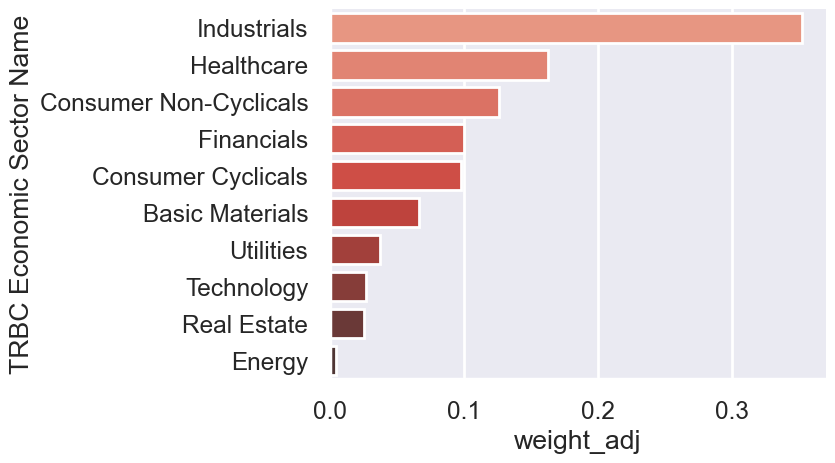

In [65]:

indus_peso = pd.DataFrame(show_big.groupby(['TRBC Economic Sector Name'])['weight_adj'].sum().sort_values(ascending=False), columns = ['weight_adj'])
display(indus_peso['weight_adj'].apply(lambda x: "{:.2%}".format(x))) 
indus_peso['weight_adj'].apply(lambda x: "{:.2%}".format(x)).to_excel(path + 'indus_peso.xlsx')
 # Peso por sector ponderado por capitalización flotante
import seaborn as sns 
sns.set_theme(style="darkgrid")
sns.set_context("poster", font_scale=0.8)
sns.barplot(x=indus_peso['weight_adj'], y=indus_peso.index, data=indus_peso, palette='Reds_d')
sns.despine()

In [186]:
price = c1[['Instrument', 'Date', 'rent_diaria']]
cols = a1[['Instrument', 'TRBC Economic Sector Name']]
rent_sector = price.merge(cols, on = 'Instrument', how='left')
rent_sector['Date'] = pd.to_datetime(rent_sector['Date'])
rent_sector['Date'] = rent_sector['Date'].dt.strftime('%Y-%m-%d')
dates = rent_sector['Date']
rent_sector.set_index(['Date'], inplace=True)
dat = dates.unique()
rets_test = pd.DataFrame()
rets_test['rets'] = 0
for i in 
    for k in dates: 
        try:
            rets_test.loc[k,'rets'] = rent_sector.loc[k].sum()[1]
        except KeyError:
            pass
        
rets_test

,rets
2018-04-20,0.000000
2018-04-23,-0.018473
2018-04-24,-0.232216
2018-04-25,-0.431234
2018-04-26,0.422388
...,...
2019-12-26,-0.213137
2020-04-13,-0.020006
2021-04-05,0.013294
2022-04-18,-0.014894


In [243]:
# Retorno Total de los sectores implicados en el índice
price = c1[['Instrument', 'Date', 'rent_diaria']]
cols = a1[['Instrument', 'TRBC Economic Sector Name']]
rent_sector = price.merge(cols, on = 'Instrument', how='left')
rent_sector['Date'] = pd.to_datetime(rent_sector['Date'])
rent_sector['Date'] = rent_sector['Date'].dt.strftime('%Y-%m-%d')
index2 = pd.MultiIndex.from_frame(rent_sector[['TRBC Economic Sector Name','Date']])
rent_sector.set_index(index2, inplace=True)
rent_sector.sort_index(level=['TRBC Economic Sector Name','Date'], inplace=True, ascending=[True, True])
rent_sector.drop(columns = ['TRBC Economic Sector Name', 'Date'], inplace=True)
sects = rent_sector.index.get_level_values(0).unique()
dates  = rent_sector.index.get_level_values(1).unique()
rent_sector['rets'] = 0

dat = dates.unique()

for i in sects:
    for k in dates: 
        try:
            a = rent_sector.loc[i, k]['rent_diaria'].sum()
            rent_sector.loc[i, k] = rent_sector.loc[i,k].replace(0, a, regex=True)
        except KeyError:
            pass
        
teste = rent_sector['rets'].drop_duplicates()
cum_sec = pd.DataFrame(columns = ['Retorno Acumulado'], index = sects)

for i in sects:
    cum_sec.loc[i]['Retorno Acumulado']=pf.timeseries.cum_returns(teste.loc[i])[-1]
    
display(cum_sec['Retorno Acumulado'].apply(lambda x: "{:.2%}".format(x)))
cum_sec.sort_values(by = 'Retorno Acumulado', ascending=False, inplace=True).sort_values(by = 'Retorno Acumulado', ascending=False, inplace=True)



TRBC Economic Sector Name
Basic Materials            -29.30%
Consumer Cyclicals         -77.33%
Consumer Non-Cyclicals      -0.22%
Energy                     -20.56%
Financials                 -99.94%
Healthcare                 320.96%
Industrials               -100.00%
Real Estate                -97.41%
Technology                  -3.89%
Utilities                  179.86%
Name: Retorno Acumulado, dtype: object

,Retorno Acumulado
TRBC Economic Sector Name,
Healthcare,3.209595
Utilities,1.798596
Consumer Non-Cyclicals,-0.002153
Technology,-0.038896
Energy,-0.205581
Basic Materials,-0.292959
Consumer Cyclicals,-0.773299
Real Estate,-0.974066
Financials,-0.999372


## Plotting rentabilidades acumuladas de los índices

Datos de Euro STOXX 50 y demás de STOXX, fuente oficial: https://qontigo.com/index/sx5e/

In [66]:
# Corregimos las rentabilidades, usando la rentabilidad ajustada sin días con menos de 40 activos
bac = pd.read_csv(path + 'index_adj_null.csv')

bac.drop(columns = ['Unnamed: 0'], inplace = True)
bac['Date'] = pd.to_datetime(bac['Date']).dt.strftime('%Y-%m-%d')
bac.set_index('Date', inplace=True)
bac.index = pd.to_datetime(bac.index)
bac.head()

,total_cap_adj,tot_rent_adj,net value adj
Date,,,
2018-04-20,8.050192e+11,0.000000,1000.000000
2018-04-23,8.062988e+11,0.001744,1001.743670
2018-04-24,8.015090e+11,-0.005689,996.044339
2018-04-25,7.933183e+11,-0.009909,986.174622
2018-04-26,8.004350e+11,0.009059,995.108204


In [98]:
# rentabilidades diarias de los índices mundiales + Propio

rics = ['.FTSE', '.STOXX50E']
bench_rets = ek.get_timeseries(rics, fields = 'CLOSE',start_date='2018-04-20', end_date='2023-04-20', interval='daily')
test = pd.DataFrame(bench_rets.pct_change())
tics = ['.SX5EESG','.FT4GDGLOB100']
bench_rets_1 = ek.get_timeseries(tics, fields = 'CLOSE',start_date='2018-04-20', end_date='2023-04-20', interval='daily')
b = pd.DataFrame(bench_rets_1.pct_change())
test = test.merge(b, on = 'Date', how='left')
dics = ['.dMIWO00000PUS', '.NDX']
bench_rets_2 = ek.get_timeseries(dics, fields = 'CLOSE',start_date='2018-04-20', end_date='2023-04-20', interval='daily')
c = pd.DataFrame(bench_rets_2.pct_change())
test = test.merge(c, on = 'Date', how='left')
#bics = ['.SPX']
#bench_rets_3 = ek.get_timeseries(bics, fields = 'CLOSE',start_date='2018-04-20', end_date='2023-04-20', interval='daily')
#d = pd.DataFrame(bench_rets_3.pct_change())
#test = test.merge(d, on = 'Date', how='left')
test.rename(columns = {'CLOSE' : '.SXWESGP'}, inplace=True)
rets = test[['.FT4GDGLOB100','.SX5EESG','.FTSE', '.STOXX50E', '.dMIWO00000PUS', '.NDX']]
rets = rets.ffill(axis  = 1)
rets.fillna(0 ,inplace=True)
test = rets.merge(bac['tot_rent_adj'], on = 'Date', how = 'left')
test.rename(columns = {'tot_rent_adj' : 'ESG Index'}, inplace=True)
test.head()

,.FT4GDGLOB100,.SX5EESG,.FTSE,.STOXX50E,.dMIWO00000PUS,.NDX,ESG Index
Date,,,,,,,
2018-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-04-23,-0.00004,0.005452,0.004167,0.005398,-0.001196,-0.002842,0.001744
2018-04-24,-0.008034,-0.00044,0.003586,-0.000621,-0.007489,-0.021019,-0.005689
2018-04-25,-0.001606,-0.006817,-0.006206,-0.007135,-0.002296,0.000752,-0.009909
2018-04-26,0.00564,0.005609,0.005706,0.005795,0.007563,0.020834,0.009059


In [101]:
# Rentabilidades anualizadas de los índices mundiales + Propio
d, err = ek.get_data(test.columns[0:6].to_list(), ['TR.IndexName'])
alpha = d['Index Name'].to_list()
alpha.insert(8, 'ESG Index')
an_rets = pd.DataFrame(alpha, columns = ['Index Name'])
an_rets['Annualized Return'] = 0
an_rets['Annualized Volatility'] = 0
for i, k in zip (test.columns, range(len(test.columns))):
    an_rets['Annualized Return'].iloc[k]=pf.timeseries.annual_return(test[i], period='daily')*100
    an_rets['Annualized Volatility'].iloc[k]=pf.timeseries.annual_volatility(test[i], period='daily')*100
an_rets['Annualized Return'] = an_rets['Annualized Return'].apply(lambda x: "{:.2f} %".format(x))
an_rets['Annualized Volatility'] = an_rets['Annualized Volatility'].apply(lambda x: "{:.2f} %".format(x))
an_rets.to_excel(path + 'an_rets.xlsx')
an_rets

,Index Name,Annualized Return,Annualized Volatility
0,FTSE4GOOD DEVELOPED 100 INDEX,8.65 %,19.42 %
1,EURO STOXX 50 ESG INDEX,5.23 %,20.13 %
2,FTSE 100,1.38 %,17.67 %
3,EURO STOXX 50 INDEX,4.55 %,20.74 %
4,WORLD,5.32 %,18.10 %
5,NASDAQ 100,11.66 %,25.94 %
6,ESG Index,11.33 %,17.24 %


In [102]:
# Rentabilidades acumuladas de los índices mundiales + Propio
test_cum = test.copy()
for i in test.columns:
   test_cum[i] = pf.timeseries.cum_returns(test[i])
test_cum

,.FT4GDGLOB100,.SX5EESG,.FTSE,.STOXX50E,.dMIWO00000PUS,.NDX,ESG Index
Date,,,,,,,
2018-04-20,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2018-04-23,-0.00004,0.005452,0.004167,0.005398,-0.001196,-0.002842,0.001744
2018-04-24,-0.008073,0.00501,0.007767,0.004774,-0.008676,-0.023801,-0.003956
2018-04-25,-0.009667,-0.001842,0.001513,-0.002395,-0.010952,-0.023068,-0.013825
2018-04-26,-0.004081,0.003757,0.007228,0.003386,-0.003472,-0.002714,-0.004892
...,...,...,...,...,...,...,...
2023-04-14,0.531529,0.30168,0.068367,0.256582,0.304245,0.768556,0.704878
2023-04-17,0.530751,0.293797,0.069399,0.24996,0.304932,0.769665,0.709848
2023-04-18,0.533335,0.302048,0.073461,0.257498,0.308925,0.770216,0.717371


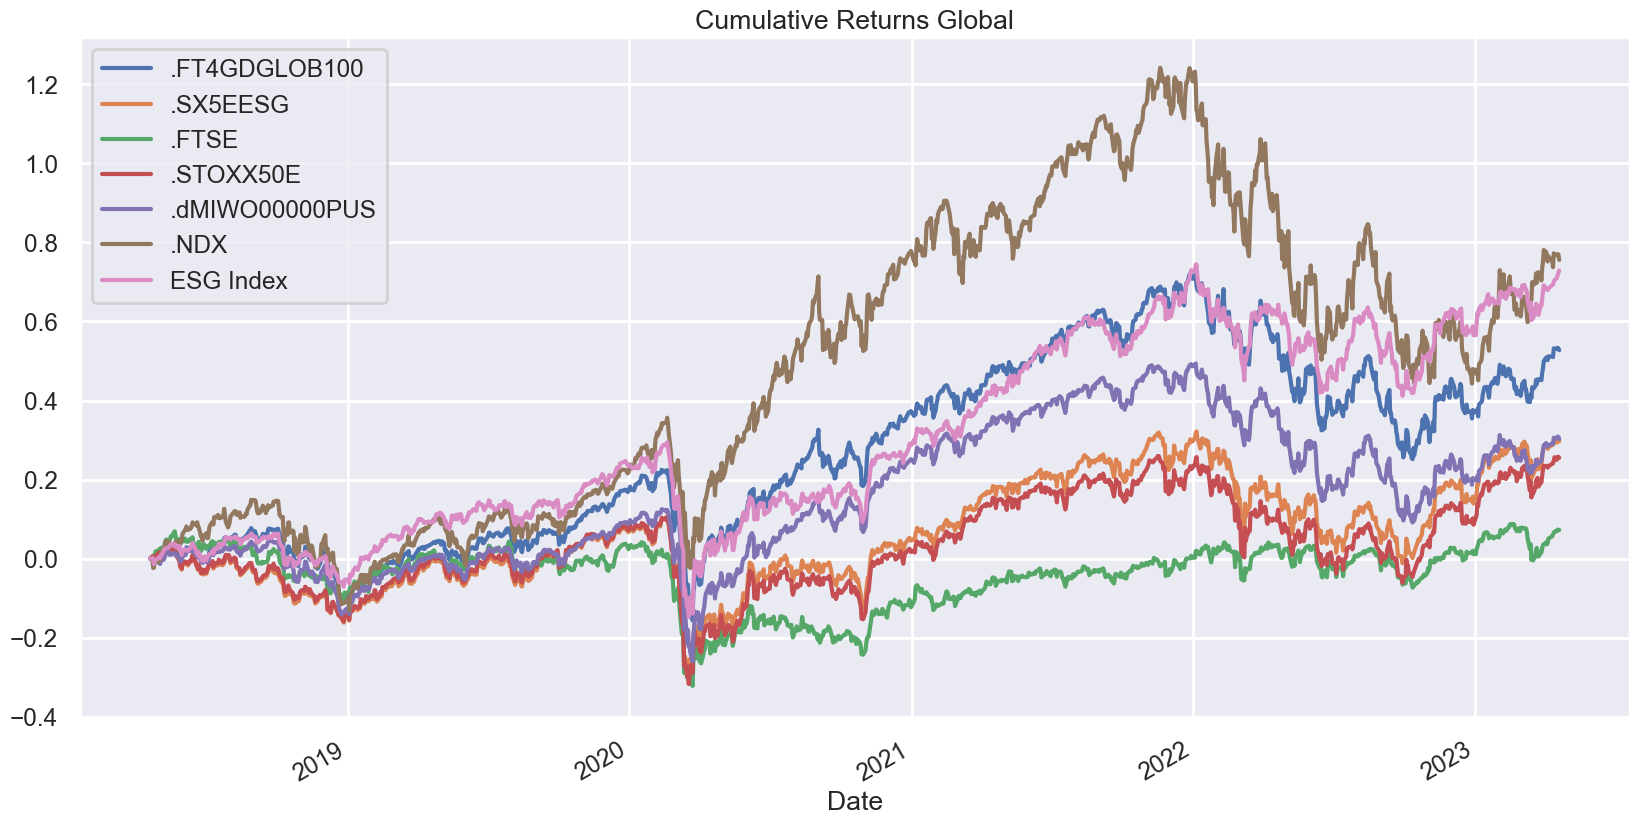

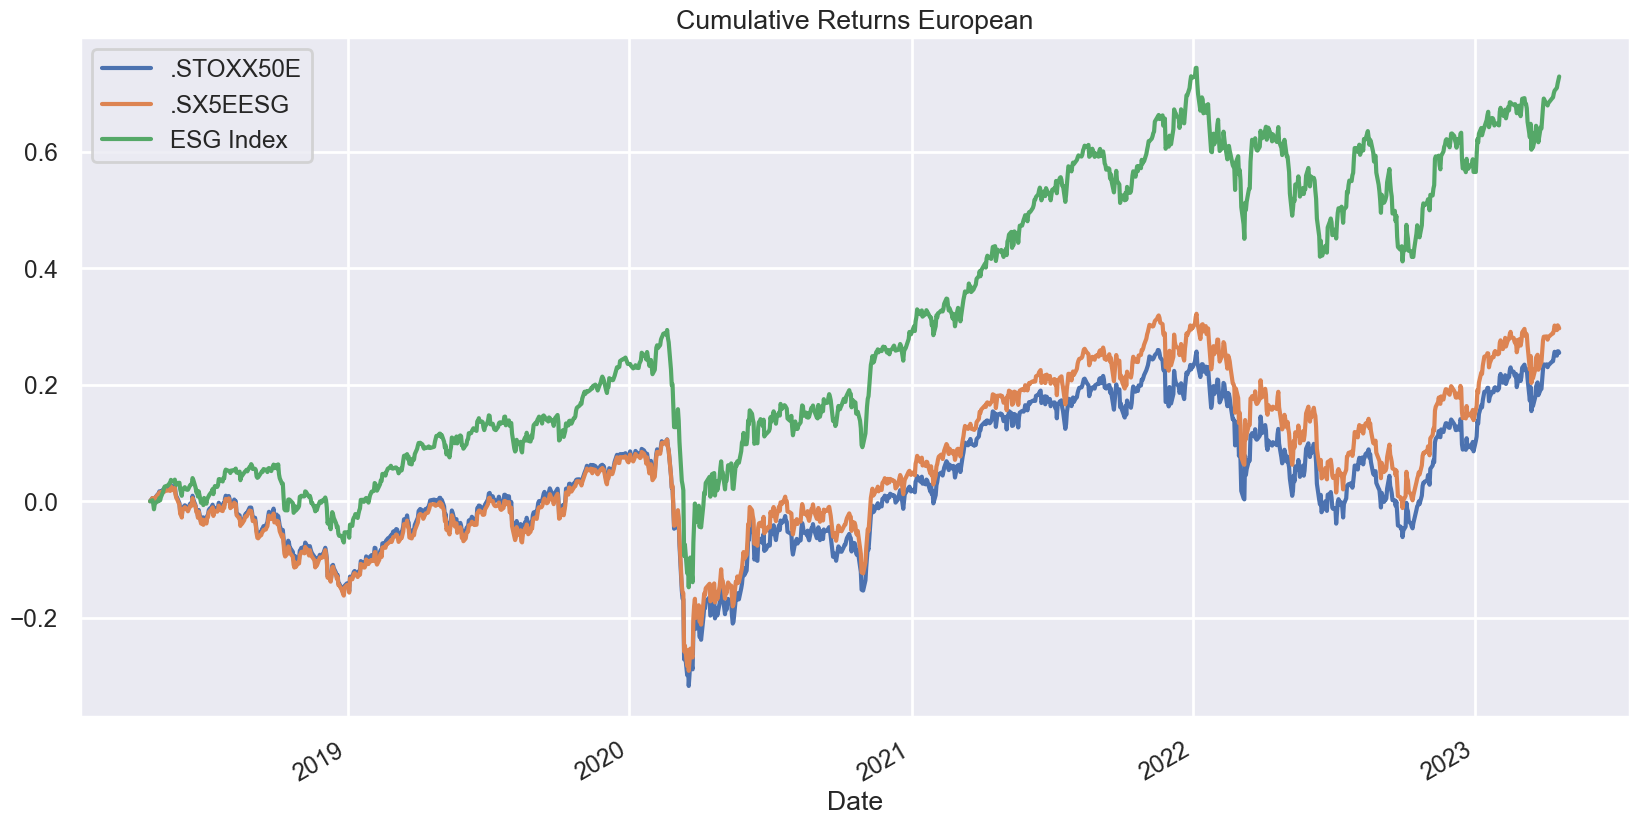

In [109]:
# Gráfico de las rentabilidades acumuladas de los índices mundiales + Propio
fig_total = test_cum.plot(figsize=(20,10), title='Cumulative Returns Global')
fig_eu = test_cum[['.STOXX50E', '.SX5EESG', 'ESG Index']].plot(figsize=(20,10), title='Cumulative Returns European')

# Guardar los gráficos
fig_total.figure.savefig(path + 'fig_total.png')
fig_eu.figure.savefig(path + 'fig_eu.png')

## Rentabilidades Acumuladas 1 / 3 / 5 años

In [103]:
# Index lists w returns

index_list = ['.FTSE', '.STOXX50E', '.SX5EESG', '.FT4GDGLOB100', '.dMIWO00000PUS', '.NDX', '.IBEX35']
d, err = ek.get_data(index_list, ['TR.IndexName','TR.IndexMktCapVendor','TR.PricePctChg1Y','TR.PricePctChg3Y','TR.PricePctChg5Y'],
                    {'Curn':'EUR'})
d

,Instrument,Index Name,Index Market Cap,1-year Price PCT Change,3-year Price PCT Change,5-year Price PCT Change
0,.FTSE,FTSE 100,1901621785461.52002,5.607538,24.901778,-2.966639
1,.STOXX50E,EURO STOXX 50 INDEX,3137845153716.509766,29.544163,30.249748,27.371806
2,.SX5EESG,EURO STOXX 50 ESG INDEX,2094218691965.199951,27.891697,30.732895,32.67171
3,.FT4GDGLOB100,FTSE4GOOD DEVELOPED 100 INDEX,20416605044216.0,21.222958,41.632067,67.77163
4,.dMIWO00000PUS,WORLD,<NA>,19.715897,33.424716,41.381836
5,.NDX,NASDAQ 100,17970349866182.199219,32.266099,47.821604,111.035564
6,.IBEX35,<NA>,<NA>,<NA>,<NA>,<NA>


In [106]:
# fechas 2018-04-20 , 2019-04-18 , 2020-04-20 , 2021-04-20 , 2022-04-20 , 2023-04-20
year1 = bac.loc['2022-04-20':]['tot_rent_adj']
year3 = bac.loc['2020-04-20':]['tot_rent_adj']
year5 = bac['tot_rent_adj']
d['Index Name'].iloc[6] = 'ESG Index'
d['Index Market Cap'].iloc[6] = bac['total_cap_adj'][-1]
cols = ['1-year Price PCT Change', '3-year Price PCT Change',
       '5-year Price PCT Change']
# calculo e introduccion de los retornos acumulados
for i, k in zip((year1, year3, year5),cols):
    d[k].iloc[6] = pf.timeseries.cum_returns(i)[-1]*100
ind_rets = d[['Index Name', 'Index Market Cap', '1-year Price PCT Change', '3-year Price PCT Change',
       '5-year Price PCT Change']]
ind_rets

,Index Name,Index Market Cap,1-year Price PCT Change,3-year Price PCT Change,5-year Price PCT Change
0,FTSE 100,1901621785461.52002,5.607538,24.901778,-2.966639
1,EURO STOXX 50 INDEX,3137845153716.509766,29.544163,30.249748,27.371806
2,EURO STOXX 50 ESG INDEX,2094218691965.199951,27.891697,30.732895,32.67171
3,FTSE4GOOD DEVELOPED 100 INDEX,20416605044216.0,21.222958,41.632067,67.77163
4,WORLD,<NA>,19.715897,33.424716,41.381836
5,NASDAQ 100,17970349866182.199219,32.266099,47.821604,111.035564
6,ESG Index,1050852363745.499146,6.953957,65.277366,72.930512


In [107]:
# formato de tabla con límite 13 - Julio - 2023 -> desfase de 2 meses con mis datos de ahi las diferencias
ind_rets['Index Market Cap'] = ind_rets['Index Market Cap'].apply(lambda x: "{:,} €".format(x))
for i in cols: 
    ind_rets[i] = ind_rets[i].apply(lambda x: "{:.2f} %".format(x))
ind_rets

,Index Name,Index Market Cap,1-year Price PCT Change,3-year Price PCT Change,5-year Price PCT Change
0,FTSE 100,"1,901,621,785,461.52 €",5.61 %,24.90 %,-2.97 %
1,EURO STOXX 50 INDEX,"3,137,845,153,716.51 €",29.54 %,30.25 %,27.37 %
2,EURO STOXX 50 ESG INDEX,"2,094,218,691,965.2 €",27.89 %,30.73 %,32.67 %
3,FTSE4GOOD DEVELOPED 100 INDEX,"20,416,605,044,216.0 €",21.22 %,41.63 %,67.77 %
4,WORLD,<NA> €,19.72 %,33.42 %,41.38 %
5,NASDAQ 100,"17,970,349,866,182.2 €",32.27 %,47.82 %,111.04 %
6,ESG Index,"1,050,852,363,745.4991 €",6.95 %,65.28 %,72.93 %


In [108]:
ind_rets = ind_rets.merge(an_rets, on = 'Index Name', how = 'left')
ind_rets

,Index Name,Index Market Cap,1-year Price PCT Change,3-year Price PCT Change,5-year Price PCT Change,Annualized Return,Annualized Volatility
0,FTSE 100,"1,901,621,785,461.52 €",5.61 %,24.90 %,-2.97 %,1.38 %,17.67 %
1,EURO STOXX 50 INDEX,"3,137,845,153,716.51 €",29.54 %,30.25 %,27.37 %,4.55 %,20.74 %
2,EURO STOXX 50 ESG INDEX,"2,094,218,691,965.2 €",27.89 %,30.73 %,32.67 %,5.23 %,20.13 %
3,FTSE4GOOD DEVELOPED 100 INDEX,"20,416,605,044,216.0 €",21.22 %,41.63 %,67.77 %,8.65 %,19.42 %
4,WORLD,<NA> €,19.72 %,33.42 %,41.38 %,5.32 %,18.10 %
5,NASDAQ 100,"17,970,349,866,182.2 €",32.27 %,47.82 %,111.04 %,11.66 %,25.94 %
6,ESG Index,"1,050,852,363,745.4991 €",6.95 %,65.28 %,72.93 %,11.33 %,17.24 %


In [80]:
ind_rets.to_excel(path + 'ind_rets.xlsx')

## Tablas y pesos del índice

In [20]:
a1.sort_values(by=['weight_adj_2023'], inplace=True, ascending=False)
a1.columns

Index(['ISIN', 'Name', 'sector_T', 'Market', 'Currency', 'Ticker',
       'Instrument', 'Tickers_YF', 'ESG Score', 'Environmental Pillar Score',
       'Social Pillar Score', 'Governance Pillar Score', 'totalEsg',
       'environmentScore', 'socialScore', 'governanceScore',
       'CO2 Equivalent Emissions Total', 'Market Cap Category',
       'Revenue from Business Activities - Total', 'carbon intensity',
       'Total CO2 Equivalent Emissions To Revenues USD in million',
       'TRBC Industry Group Name', 'TRBC Economic Sector Name', 'Date',
       'GHG Emissions Scope 1,2,3 to Revenue USD in million', 'weight_adj',
       'weighted emissions in MILL', 'log_cap', 'mkt_cap_2023_EUR',
       'weight_adj_2023', 'weight_2023'],
      dtype='object')

In [21]:
w_tab = a1[['Name', 'TRBC Economic Sector Name', 'weight_adj_2023', 'weight_2023']]
w_tab ['Diferencia'] = (w_tab['weight_adj_2023'] - w_tab['weight_2023'])/w_tab['weight_2023']
cols = ['weight_adj_2023', 'weight_2023', 'Diferencia']
for i in cols: 
    w_tab[i] = (w_tab[i]*100).apply(lambda x: "{:.2f} %".format(x))
w_tab 

,Name,TRBC Economic Sector Name,weight_adj_2023,weight_2023,Diferencia
23,NOVARTIS AG,Healthcare,13.67 %,17.73 %,-22.88 %
9,DIAGEO,Consumer Non-Cyclicals,9.00 %,8.17 %,10.17 %
8,COMPAGNIE FINANCIERE RICHEMONT SA,Consumer Cyclicals,7.63 %,6.93 %,10.17 %
24,VINCI,Industrials,6.20 %,5.63 %,10.17 %
27,ABB LTD,Industrials,6.03 %,5.47 %,10.17 %
34,RELX,Industrials,5.52 %,5.01 %,10.17 %
28,ATLAS COPCO AB,Industrials,5.22 %,4.74 %,10.17 %
25,DSV A/S,Industrials,3.55 %,3.22 %,10.17 %
29,TRANE TECHNOLOGIES PLC,Industrials,3.49 %,3.17 %,10.17 %
20,ASSICURAZ.GEN.ORD.,Financials,2.83 %,2.57 %,10.17 %


In [22]:
w_tab.rename(columns={'Name':'Compañía','weight_adj_2023':'Peso con Flotación', 'weight_2023':'Peso Simple'}, inplace=True)
w_tab.to_excel(path + 'w_tab.xlsx')
w_tab.head(10)

,Compañía,TRBC Economic Sector Name,Peso con Flotación,Peso Simple,Diferencia
23,NOVARTIS AG,Healthcare,13.67 %,17.73 %,-22.88 %
9,DIAGEO,Consumer Non-Cyclicals,9.00 %,8.17 %,10.17 %
8,COMPAGNIE FINANCIERE RICHEMONT SA,Consumer Cyclicals,7.63 %,6.93 %,10.17 %
24,VINCI,Industrials,6.20 %,5.63 %,10.17 %
27,ABB LTD,Industrials,6.03 %,5.47 %,10.17 %
34,RELX,Industrials,5.52 %,5.01 %,10.17 %
28,ATLAS COPCO AB,Industrials,5.22 %,4.74 %,10.17 %
25,DSV A/S,Industrials,3.55 %,3.22 %,10.17 %
29,TRANE TECHNOLOGIES PLC,Industrials,3.49 %,3.17 %,10.17 %
20,ASSICURAZ.GEN.ORD.,Financials,2.83 %,2.57 %,10.17 %
